In [1]:
words = open('names.txt', 'r').read().splitlines()

In [7]:
import torch 
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn.functional as F

In [11]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [55]:
n_embed = 3 # This is the dimentions of the embeddings. Each character will be defined as a 2D embedding
vocab_size = 27 # This is the size of the vocabulary.

n_hidden = 200
g = torch.Generator().manual_seed(2147483646)
C = torch.randn((vocab_size, n_embed), generator=g)

W1 = torch.randn((n_embed * block_size, n_hidden), generator=g)
B1 = torch.randn(n_hidden, generator=g)

W2 = torch.randn((n_hidden, vocab_size), generator=g)
B2 = torch.randn(vocab_size, generator=g)

parameters = [C, W1, B1, W2, B2]

In [56]:
# Let's set requires_grad to True for all parameters
for p in parameters: 
    p.requires_grad = True

In [57]:

lossi = []
epochs = 200000
batch_size = 32
for k in range (epochs):
    # forward pass
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    X_onehot = F.one_hot(Xtr[ix], num_classes=vocab_size).float()
    emb = X_onehot @ C
    embeddings = emb.flatten(start_dim=1, end_dim=-1)
    h = torch.tanh(embeddings @ W1 + B1)
    logits = h @ W2 + B2
    # compute nll loss
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())
    # update the grad to None
    for p in parameters: 
        p.grad = None

    # Backward pass 
    loss.backward()
    
    
    # Update the values of the parameters 
    e = 0.1 if k < 100000 else 0.01
    for p in parameters: 
        p.data -= e * p.grad

    if k % 50000 == 0:
        print(f"loss: {loss}")

    lossi.append(loss.log10().item())
    
print(loss.item())

loss: 23.809009552001953
loss: 2.3795711994171143
loss: 2.3345015048980713
loss: 2.2014472484588623
1.9464160203933716


In [61]:
    X_onehot = F.one_hot(Xdev, num_classes=vocab_size).float()
    emb = X_onehot @ C
    embeddings = emb.flatten(start_dim=1, end_dim=-1)
    h = torch.tanh(embeddings @ W1 + B1)
    logits = h @ W2 + B2
    # compute nll loss
    loss = F.cross_entropy(logits, Ydev)
    loss

tensor(2.2119, grad_fn=<NllLossBackward0>)

In [66]:
@torch.no_grad()
def evaluate_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'validation': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]

    X_onehot = F.one_hot(x, num_classes=vocab_size).float()
    emb = X_onehot @ C
    embeddings = emb.flatten(start_dim=1, end_dim=-1)
    h = torch.tanh(embeddings @ W1 + B1)
    logits = h @ W2 + B2
    loss = F.cross_entropy(logits, y)
    return loss

In [67]:
print(f"Train loss: {evaluate_loss('train')}")
print(f"Validation loss: {evaluate_loss('validation')}")

Train loss: 2.2025563716888428
Validation loss: 2.2119126319885254


### We will try improving this loss by looking at some hidden properties of the network. 
We will look at how the activations and gradients behave during training. 

Initial loss after training but before optimizing: 
<br/>
Training loss = 2.12
<br/>
Validation loss = 2.19

### Let's start by plotting the loss that we have accumulated while training. 
The loss that we are plotting is actually log10 of the loss value over iterations. This is simply to make the plot more viewable.


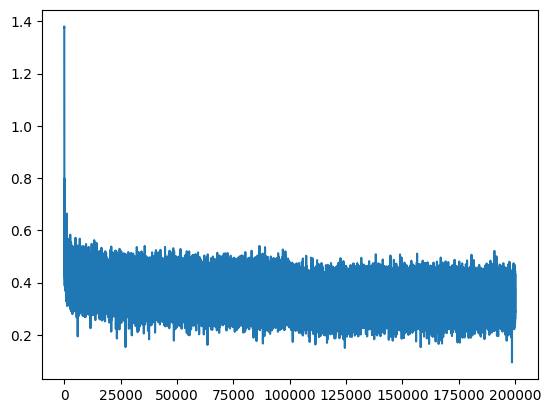

In [68]:
plt.plot(lossi)

Let's make some observations. 
<p>The initial loss that we are recording is 23.8. In the very next few iterations during training, this loss drops drastically to the range close to 3. This tells us the <b>Initialisation</b> of the model (weights and biases values) are not correct.</p>
<p>In a model based on a problem, you'd always roughly have an idea of what the initial loss would be. It can be calculated as well. We'll calculate what range our initial loss should fall into.</p>

<p>Let's talk about what is happening right now, first. The loss is much too high at the initialisation. At the time of initialisation, we have randomly assigned weights. Because of these randomly assigned weights, the probabilities that are coming out of the model are also randomly spread out. The model is therefore, assigning very high probability to some characters and very low probability to others. Because of this, the model is <b>Wrongly very highly Confident</b> about some characters and <b>Very under-confident</b> about others. This is what is causing the initial loss to be so high.</p>
<p>What we would like in the beginning is the model to assign almost equal probability to every character, instead, also known as <b>Uniform Distribution</b>. It also makes sense, logically, right? Since the model has not learnt anything yet, why should the model feel that any character is more likely to come as the next character than any other!</p>

<p>There are 27 possible characters that can come as the next character. What would be the probability of each character as the next character? It will be <b>(1 / 27)</b>. Thus what we would expect, is the model to roughl assign a probability of 1/27 to each character at the time of initialisation.</p>

<p>If the model were assigning the probability of 1/27 to each character, what would be the loss that we would expect? Let's calculate that.</p>

In [72]:
expected_nll = -torch.tensor(1/27).log()
expected_nll

tensor(3.2958)

According to the above computation, we would expect a negative log likelyhood loss to be closs to 3.2. Which is far lesser than 23!

<p>Good question to ask here is, <b>We don't directly control the probabilities that come out of the model, right</b>? The probabilities that we compute are a function (softmax function) of the logits that we get. Let's look at how the values of logits affect these probabilities.</p>

Let's imagine a 4 dimensional tensor of logit values.

In [78]:
logits = torch.tensor([0.0, 0.0, 0.0, 0.0]) 
probs = torch.softmax(logits, dim=0)
loss = -probs.log()
probs, loss

(tensor([0.2500, 0.2500, 0.2500, 0.2500]),
 tensor([1.3863, 1.3863, 1.3863, 1.3863]))

As we can see above, the probabilities are amost equal if the initial logits are almost equal. 
If any of these logits take a very high value in the beginning, the probabilities will not be close to each other and the loss would also be an extreme value.  

In [100]:
logits = torch.randn(4)
probs = torch.softmax(logits, dim=0)
loss = -probs.log()
logits, probs, loss, logits.std()

(tensor([-0.6662, -0.8936, -0.6226, -0.5574]),
 tensor([0.2528, 0.2014, 0.2640, 0.2818]),
 tensor([1.3752, 1.6027, 1.3317, 1.2664]),
 tensor(0.1461))

torch.randn gives random values from a normal distribution, with mean 0 and variance 1. 
As can be seen, the standard deviation of logits is ~ 1. That's what torch.randn provides. Over a large enough sample, the variance converges to 1.
This tells us that the values are not that far from the mean.

Hence all the values are not that far extreme from one another. Because of this, the probabilities and the losses are also close to one another. 

Let's mulitply the randn tensor by a factor of 10. This would result in the logits to be much farther away from each other.

In [106]:
logits = torch.randn(4) * 10
probs = torch.softmax(logits, dim=0)
loss = -probs.log()
logits, probs, loss, logits.std()

(tensor([ 4.1154, 29.7002,  0.9878, -2.5610]),
 tensor([7.7386e-12, 1.0000e+00, 3.3912e-13, 9.7534e-15]),
 tensor([25.5848, -0.0000, 28.7124, 32.2612]),
 tensor(14.6820))

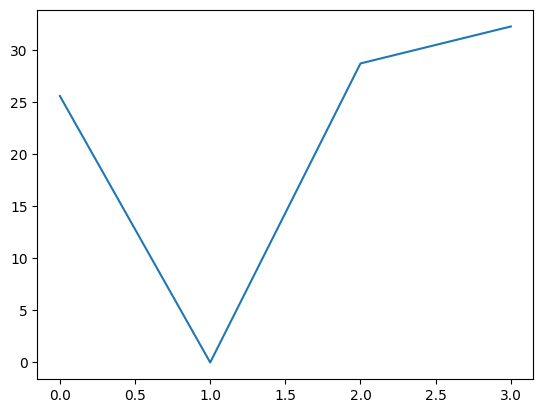

In [108]:
plt.plot(loss)

And there you go! You can see that the probabilities and the loss for each logit are also much farther from one another!
The standard deviation is also so much higher than 1. This shows how far away the logits are from the mean.
This is exactly what we do not want. 
<p>So a good rule of thumb is, the logits at initilisation should be very close to 0 (or equal, thus assigning almost equal probability to each character). </p>

### We have a good idea now, of what it is that we want to achieve. 
Let's now examine the paramters and see what could be causing the logits to be so far away from one another (or far away from the mean). 
<br/>We have 2 layers, let's examine what the logits are a function of. We know that logits are given by:
$$
    logits = W2h + B2
$$
where, W2 are the weights of the neurons of second layer and B2 are the biases of those neurons. 

We notice the following things right off the bat.
1. We are simply adding biases. We have randomly assigned biases to begin with. This offsets the logits by a certain value, thus moving them further away from having a variance of 1.
2. We are multiplying the output of the hidden layer with weights W2. Now, W2 are also randomly assigned. Even though their variance would be close to 1, but due to the multiplicative operation, the product would not necessarily follow this property.
<br/>
Let's try a couple of things to fix this.
1. Let's initiaise the B2 as 0. Since B2 is an additive operation, we do not want any offset added to our logits. Hence, set to 0.
2. Let's scale down W2 by a factor of 0.01, so that their distances from the mean and one another reduces even further (they become very small values). Why not make them zero? Well, the logits will become zero due to the multiplication.
3. <p>I'll re-initialise the parameters and train the model, but break out of the training loop right after the first iteration. Let's see how these changes affect our initial loss.</p>

In [114]:
n_embed = 3 # This is the dimentions of the embeddings. Each character will be defined as a 2D embedding
vocab_size = 27 # This is the size of the vocabulary.

n_hidden = 200
g = torch.Generator().manual_seed(2147483646)
C = torch.randn((vocab_size, n_embed), generator=g)

W1 = torch.randn((n_embed * block_size, n_hidden), generator=g)
B1 = torch.randn(n_hidden, generator=g)

W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01 # Scalled down to 0.01
B2 = torch.randn(vocab_size, generator=g) * 0 # Initialised to zero.

parameters = [C, W1, B1, W2, B2]

# Let's set requires_grad to True for all parameters
for p in parameters: 
    p.requires_grad = True

In [115]:

lossi = []
epochs = 200000
batch_size = 32
for k in range (epochs):
    # forward pass
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    X_onehot = F.one_hot(Xtr[ix], num_classes=vocab_size).float()
    emb = X_onehot @ C
    embeddings = emb.flatten(start_dim=1, end_dim=-1)
    h = torch.tanh(embeddings @ W1 + B1)
    logits = h @ W2 + B2
    # compute nll loss
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())
    # update the grad to None
    for p in parameters: 
        p.grad = None

    # Backward pass 
    loss.backward()
    
    
    # Update the values of the parameters 
    e = 0.1 if k < 100000 else 0.01
    for p in parameters: 
        p.data -= e * p.grad

    if k % 50000 == 0:
        print(f"loss: {loss}")

    lossi.append(loss.log10().item())
    break
    
print(loss.item())

loss: 3.2887730598449707
3.2887730598449707


We were able to significantly reduce the initial loss from almost 24 to 3.28!

In [117]:
logits[0], logits[0].std()

(tensor([-0.1657,  0.2050, -0.1457,  0.1156, -0.0224,  0.0713, -0.0656,  0.1373,
         -0.1415, -0.0661,  0.1419,  0.0502, -0.0189,  0.0812, -0.1875,  0.0388,
         -0.1073, -0.1240,  0.0224, -0.0504, -0.2428,  0.0467, -0.0298,  0.0718,
         -0.0696, -0.1032,  0.1301], grad_fn=<SelectBackward0>),
 tensor(0.1154, grad_fn=<StdBackward0>))

The logits are also much closer to zero now. The standard deviation is also well within the required range.

In [210]:
n_embed = 3 # This is the dimensions of the embeddings. Each character will be defined as a 3D embedding
vocab_size = 27 # This is the size of the vocabulary.

n_hidden = 200
g = torch.Generator().manual_seed(2147483646)
C = torch.randn((vocab_size, n_embed), generator=g)

W1 = torch.randn((n_embed * block_size, n_hidden), generator=g)
B1 = torch.randn(n_hidden, generator=g)

W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01 # Scalled down to 0.01
B2 = torch.randn(vocab_size, generator=g) * 0 # Initialised to zero.

parameters = [C, W1, B1, W2, B2]

# Let's set requires_grad to True for all parameters
for p in parameters: 
    p.requires_grad = True

In [211]:

lossi = []
epochs = 200000
batch_size = 32
for k in range (epochs):
    # forward pass
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    X_onehot = F.one_hot(Xtr[ix], num_classes=vocab_size).float()
    emb = X_onehot @ C
    embeddings = emb.flatten(start_dim=1, end_dim=-1)
    h = torch.tanh(embeddings @ W1 + B1)
    logits = h @ W2 + B2
    # compute nll loss
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())
    # update the grad to None
    for p in parameters: 
        p.grad = None

    # Backward pass 
    loss.backward()
    
    
    # Update the values of the parameters 
    e = 0.1 if k < 100000 else 0.01
    for p in parameters: 
        p.data -= e * p.grad

    if k % 50000 == 0:
        print(f"loss: {loss}")

    lossi.append(loss.log10().item())
    
print(loss.item())

loss: 3.2739434242248535
loss: 1.9734526872634888
loss: 2.1078946590423584
loss: 1.9262865781784058
2.176816940307617


In [212]:
print(f"Train loss: {evaluate_loss('train')}")
print(f"Validation loss: {evaluate_loss('validation')}")

Train loss: 2.1237337589263916
Validation loss: 2.1633377075195312


The validation loss has reduced to 2.16, as opposed to 2.19 prior to initilisation optimization. 
### Why do we need to worry about correctly initiliase the loss, any way?
<b>My model's loss comes down eventually, why do I need to worry about what the initial loss was? </b>
<p>This is a great question to ask. Well, the simple answer to this is, since the model was so highly wrongly confident (thus a high loss) at the beginning, some of the training iterations simply get wasted just to squash the loss value to the correct range. That is exactly why the loss falls so drastically. This is a wasted opportunity of the training, as in those iterations, the model could actually have been learning, instead of just brining the loss in the correct range.</p>

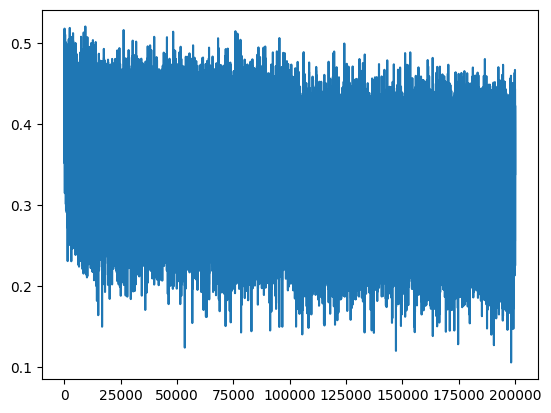

In [213]:
plt.plot(lossi)

Plotting the log10 of loss, we can see that it loses that initial high value, also known as the <b>Hockey Stick Appearance</b>. It starts off a reasonable value. Thus we can be fairly certain that during the iterations of training, the model is actually spending more time and iterations optimizing or learning, instead of spending a first few thousands of iterations just squashing down the bloated loss. 

### Dealing with saturated activation function
Now that we have fixed the initialisation loss, let's look at the another problem that is lurking in the nueral net. 
<br/> Let's reinitialise the network and go from there. In the network code, I'll be separating the tanh operation in a new variable, so we can examine it more closely. 

In [131]:
n_embed = 3 # This is the dimentions of the embeddings. Each character will be defined as a 2D embedding
vocab_size = 27 # This is the size of the vocabulary.

n_hidden = 200
g = torch.Generator().manual_seed(2147483646)
C = torch.randn((vocab_size, n_embed), generator=g)

W1 = torch.randn((n_embed * block_size, n_hidden), generator=g)
B1 = torch.randn(n_hidden, generator=g)

W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01 # Scalled down to 0.01
B2 = torch.randn(vocab_size, generator=g) * 0 # Initialised to zero.

parameters = [C, W1, B1, W2, B2]

# Let's set requires_grad to True for all parameters
for p in parameters: 
    p.requires_grad = True

In [132]:

lossi = []
epochs = 200000
batch_size = 32
for k in range (epochs):
    # forward pass
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    X_onehot = F.one_hot(Xtr[ix], num_classes=vocab_size).float()
    emb = X_onehot @ C
    embeddings = emb.flatten(start_dim=1, end_dim=-1)
    hpreact = embeddings @ W1 + B1
    h = torch.tanh(hpreact)
    logits = h @ W2 + B2
    # compute nll loss
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())
    # update the grad to None
    for p in parameters: 
        p.grad = None

    # Backward pass 
    loss.backward()
    
    
    # Update the values of the parameters 
    e = 0.1 if k < 100000 else 0.01
    for p in parameters: 
        p.data -= e * p.grad

    if k % 50000 == 0:
        print(f"loss: {loss}")

    lossi.append(loss.log10().item())
    break

loss: 3.3030779361724854


The initial loss is what we would expect.
But let us examine the activation layer of the hidden network, i.e, the variable h. 

In [140]:
h

tensor([[-1.0000,  0.2508,  0.9999,  ..., -0.9578, -0.6693,  0.9999],
        [ 1.0000, -0.8831, -1.0000,  ...,  0.9968, -0.5631, -0.9995],
        [-0.9977, -0.9995,  0.9937,  ..., -0.1637,  0.5568,  1.0000],
        ...,
        [-0.9980, -0.9999,  0.9995,  ..., -0.8559,  0.8747,  1.0000],
        [-0.9968, -0.1453,  0.9893,  ...,  0.9977, -0.9535,  1.0000],
        [-0.4912,  0.0537,  0.9997,  ...,  0.9411, -0.5248,  0.9057]],
       grad_fn=<TanhBackward0>)

<p>I would like to draw your attention to how many values in the hidden layer output are 1.0 or -1.0.</p>
<p>Is that a problem? Before we move forward, let's do a refresher on the tanh function. The tanh function has a squashing property, in that it squashes the values between the ranges [-1, 1]. And values greater than 1 will be be squashed to 1, and any values lesser than -1 will be squashed down to -1.</p>

<p>Let's look at a histogram of the hidden layer output, first.</p>


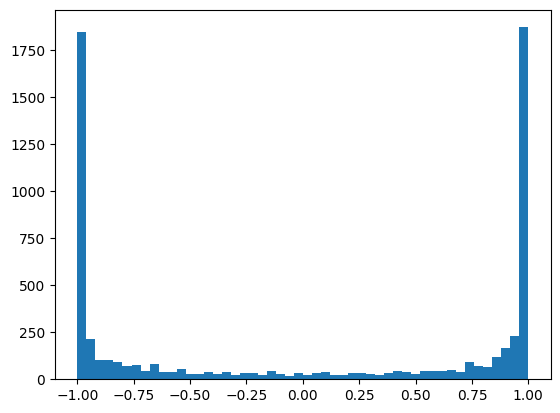

In [154]:
plt.hist(h.flatten().tolist(), 50);

This gives us the count of how many values are 1 and -1. As you can see, almost 2500 values inside h are 1 and almost the same are -1. 
This clearly means that most of the values which are being passed to the tanh function are either greater than 1 or lesser than -1.
<p>This means that the tanh is very <b>Active</b>.</p>
<p>Let's look at the histogram of the data that is being fed to the tanh function, also known as the pre-activation.</p>

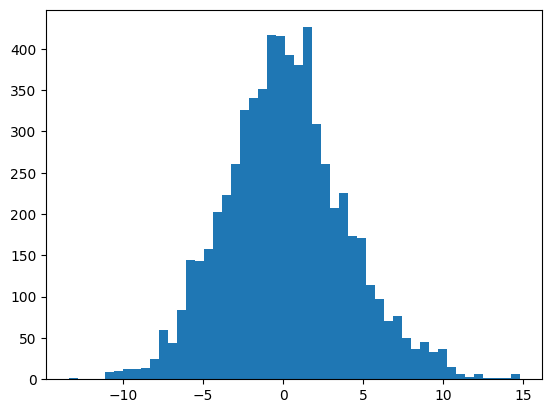

In [158]:
plt.hist(hpreact.flatten().tolist(), 50);

As can be seen, the distribution of the pre-activation data is very broad. It takes values from -10 to 15. Which is why the tanh function is squashing so much of it and we are getting so many 1s and -1s in the tanh activation output.

### How is this a problem, though?
Well, looking at just the histograms, the problem is not very apparent. Although, if you have understood the backpropogation and gradients well enough so far, you are looking at the tanh activation and sweating. 

<p>Not sweating already? Let me help you see the problem and sweat. What is a very crucial step that we do while training a network? It is the line <b>loss.backward()</b></p>
<p>We back propogate through the network, computing gradients of each parameter wrt to the loss. This is what tells us, how would the loss change as well change these weights.</p>

<p>The way back propogation works is, we move backward through all the mathematical operations that we have done in the forward pass, and using chain rule, we compute the gradient at each operation. The problematic operation here, is the <b>tanh.</b></p>

</br>What is the derivative of tanh wrt its next operation?
$$
    d(tanh(x)) / dx = 1 - (tanh(x))**2
$$

<p>But this is the local gradient. In order to obtain the gradient of tanh wrt to the loss, we apply the chain rule and multiply it with the gradient obtained so far, before this in the backpropogation. Let 'out' be the tanh operation output and the grad of 'out' wrt to loss is 'grad'.</p>

$$
    gradient wrt loss = (1 - (tanh(x))**2 ) * grad
$$

<p>Well, do you see the problem now, should x take values greater than 1 or smaller than -1? In other words, do you see the problem now, should tanh become -1 or 1? <b>The gradient becomes 0!</b></p>


At the tanh neuron, we are essentially killing the gradient. Which means, it does not propogate back to the weights. Let's understand it more intuitively. But first, let's look at the tanh graph.

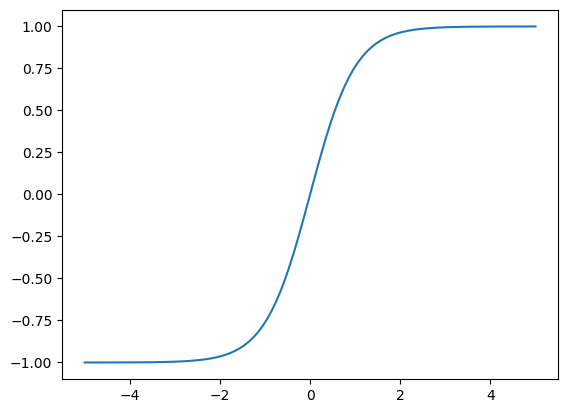

In [163]:
import numpy as np
x = np.linspace(-5, 5, 100)
y = np.tanh(x)
plt.plot(x, y)

The <b>Flat</b> regions of the tanh graph, also known as the <b>tail</b>, depict the values of input which are greater than 1 or less than -1. 

#### Let's look at it intuitively
<p>Imagine the weights to be the inputs to this tanh function. And imagine the graph to be output of tanh being applied to those weights. 
For the weight values greater than 1 and less than -1, the graph is flat, which means the slope is 0. Hence, no matter what changes I make to the weights, the output of this tanh will not change. If this becomes the case of my network, it simply means that no matter how much I train my network, it will never learn (more preceisely, that neuron will never learn). Since updating the weights will never reduce the loss.</p>

Let's look at another graph to see how this affects our network. 

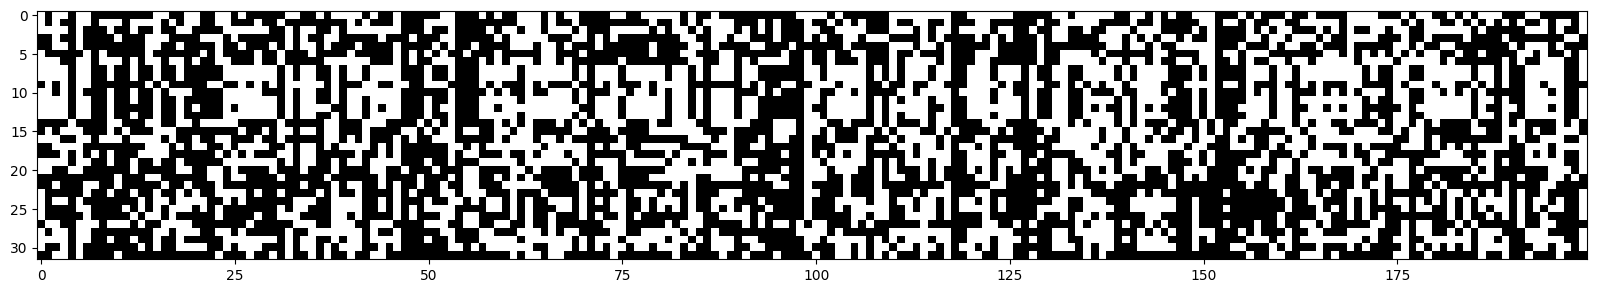

In [166]:
plt.figure(figsize=(20, 10));
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

The above image is of a boolean tensor becuase of <i>h.abs() > 0.99</i>.
We get a white pixel, if it is true and a black if it is false. 
<p>You can see, how many of the pixels are white, which means so many of the input values to tanh are greater than 1 or less than -1.</p>
<p>What else does it signify? The shape of 'h' is [32, 200]. Which means there are 32 rows, of 200 neurons each, since there are 32 examples.Hence, even in the graph above, there are 32 rows. The columns depict the number of neurons.</p>
<p>Imagine a scenario, where an entire column is white. This would signify, that for all the 32 batch size inputs, this particular tanh neruon produced values of 1 or -1. This point is very very crucial and I'll explain what this means. But before that, let's create an example depicting this. </p>

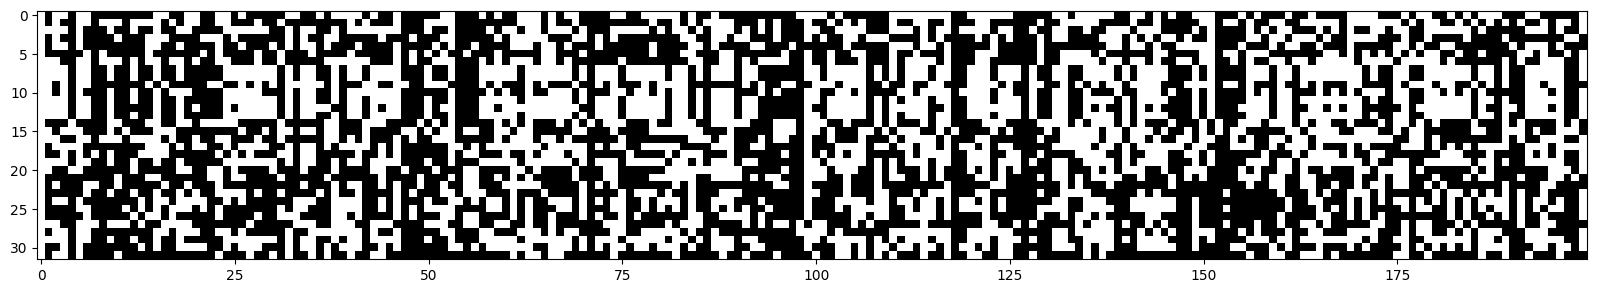

In [182]:
h_temp = h.clone().detach()
h_temp[:, 0] = 1.0

plt.figure(figsize=(20, 10));
plt.imshow(h_temp.abs() > 0.99, cmap='gray', interpolation='nearest')

In [186]:
h_temp_grad = 1 - h_temp**2

h_temp_grad[:, 0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])

<p>What we did here is, we set the entire column 0 to 1. This simulates that the neuron indexed 0 (out of 200 neurons), produces the output equal to 1. Remember, this is a tanh neruon. During back propogation, the grad of this neuron will be computed, one for each input in the batch size.</p>
<p>Then we computed the grad of the neurons as 'h_temp_grad'. As you can see, the grad of neuron at index 0 is 0 for all the 32 inputs. <b>This signifies that this neuron will never learn from any of the inputs, thus making this a <b>Dead Neuron</b>. The weights which feed into this neuron will never get updated.</b></p>
This is a big problem, since we have a network in which a neuron is just not learning. 

#### Ofcourse the problem is clear now, but looking at the graph, it also gives us the sense of how to solve it!
It is clear that if the input to the tanh neuron is largely distributed (have a lot of values greater than 1 or less than -1), most of the outputs will be 1 or -1. 
<p>This also kind of gives off an intiuitive solution to the problem. Let's look at what gets fed into the tanh layer.</p>
<p>The output of the hidden layer is, defined as tanh(embeddings @ W1 + B1). Hence what gets fed into the tanh layer is (embeddings @ W1 + B1). If we make sure that this expression always outputs values within the range of (-1, 1), this tanh saturation problem should go away.</p>

<p>In our code, <i>embeddings @ W1 + B1</i> term is called <i>hpreact</i>. We want this output to be well within the range of (-1, 1). Let's use the same approach as in the previous optimization and scale down the W1 by a factor of 0.1 and biases also by a factor of 0.01. We can set the biases to zero, but keeping them very small number, instead of zero, introduces some amount of entropy in the values, causing some variation which could be good for the network.</p>

In [187]:
n_embed = 3 # This is the dimentions of the embeddings. Each character will be defined as a 2D embedding
vocab_size = 27 # This is the size of the vocabulary.

n_hidden = 200
g = torch.Generator().manual_seed(2147483646)
C = torch.randn((vocab_size, n_embed), generator=g)

W1 = torch.randn((n_embed * block_size, n_hidden), generator=g) * 0.1 # Scalled down to 0.1
B1 = torch.randn(n_hidden, generator=g) * 0.01 # Scalled down to 0.01

W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01 # Scalled down to 0.01
B2 = torch.randn(vocab_size, generator=g) * 0 # Initialised to zero.

parameters = [C, W1, B1, W2, B2]

# Let's set requires_grad to True for all parameters
for p in parameters: 
    p.requires_grad = True

In [188]:

lossi = []
epochs = 200000
batch_size = 32
for k in range (epochs):
    # forward pass
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    X_onehot = F.one_hot(Xtr[ix], num_classes=vocab_size).float()
    emb = X_onehot @ C
    embeddings = emb.flatten(start_dim=1, end_dim=-1)
    hpreact = embeddings @ W1 + B1
    h = torch.tanh(hpreact)
    logits = h @ W2 + B2
    # compute nll loss
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())
    # update the grad to None
    for p in parameters: 
        p.grad = None

    # Backward pass 
    loss.backward()
    
    
    # Update the values of the parameters 
    e = 0.1 if k < 100000 else 0.01
    for p in parameters: 
        p.data -= e * p.grad

    if k % 50000 == 0:
        print(f"loss: {loss}")

    lossi.append(loss.log10().item())
    break

loss: 3.295116901397705


Let's check out the histogram of output of the tanh. Also, let's check out the distribution of the input to the tanh, ie hpreact.

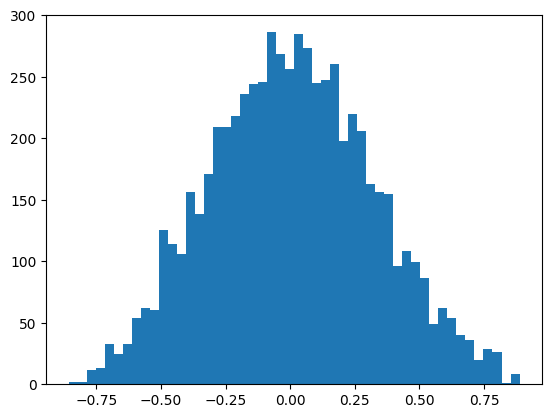

In [189]:
plt.hist(h.flatten().tolist(), 50);

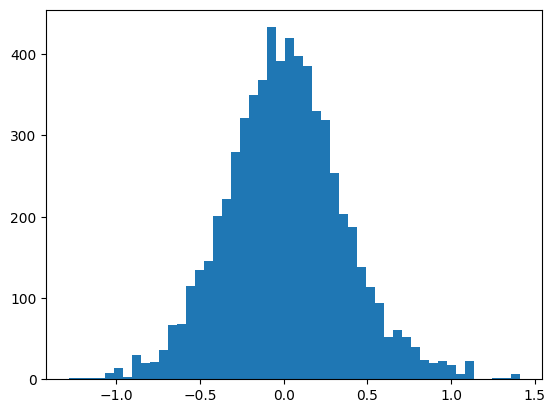

In [190]:
plt.hist(hpreact.flatten().tolist(), 50);

<p>As you can see from the histogram of tanh output (which is h), it is no longer saturated. Most of the values are well within the range of (-1, 1). Because of this, the gradient of tanh operation will never be zero.</p>

<p>Also, the histogram of <i>hpreact</i> is not widely distributed. It is within the range of -1 to 1.5, as opposed to the last time,  when it was between -10 to 15 (which was a very high distribution).</p>

In [193]:
h.std(), h.mean(), hpreact.std(), hpreact.mean()

(tensor(0.3159, grad_fn=<StdBackward0>),
 tensor(0.0076, grad_fn=<MeanBackward0>),
 tensor(0.3555, grad_fn=<StdBackward0>),
 tensor(0.0106, grad_fn=<MeanBackward0>))

You can look at the standard deviations of h and hpreact are less than 1, with means very close to 0. 
<p>Let's look at the boolean tensor of h now. Just to make sure that we are not hitting "white" regions a lot.</p>

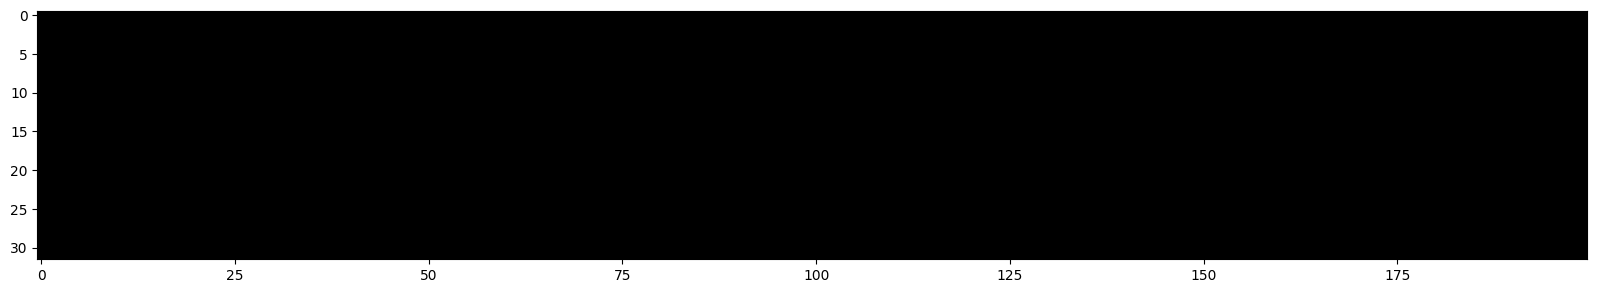

In [194]:
plt.figure(figsize=(20, 10));
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

Wow, there are no white pixels! This indicates that the gradient for no value will ever be zero. Thus, the neuron will learn foe every single input, making it learn much more during training. 

Let's train the model again, and see if it improves are loss!

In [214]:
n_embed = 3 # This is the dimentions of the embeddings. Each character will be defined as a 2D embedding
vocab_size = 27 # This is the size of the vocabulary.

n_hidden = 200
g = torch.Generator().manual_seed(2147483646)
C = torch.randn((vocab_size, n_embed), generator=g)

W1 = torch.randn((n_embed * block_size, n_hidden), generator=g) * 0.2 # Scalled down to 0.2
B1 = torch.randn(n_hidden, generator=g) * 0.01 # Scalled down to 0.01

W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01 # Scalled down to 0.01
B2 = torch.randn(vocab_size, generator=g) * 0 # Initialised to zero.

parameters = [C, W1, B1, W2, B2]

# Let's set requires_grad to True for all parameters
for p in parameters: 
    p.requires_grad = True

In [215]:

lossi = []
epochs = 200000
batch_size = 32
for k in range (epochs):
    # forward pass
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    X_onehot = F.one_hot(Xtr[ix], num_classes=vocab_size).float()
    emb = X_onehot @ C
    embeddings = emb.flatten(start_dim=1, end_dim=-1)
    hpreact = embeddings @ W1 + B1
    h = torch.tanh(hpreact)
    logits = h @ W2 + B2
    # compute nll loss
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())
    # update the grad to None
    for p in parameters: 
        p.grad = None

    # Backward pass 
    loss.backward()
    
    
    # Update the values of the parameters 
    e = 0.1 if k < 100000 else 0.01
    for p in parameters: 
        p.data -= e * p.grad

    if k % 50000 == 0:
        print(f"loss: {loss}")

    lossi.append(loss.log10().item())

loss: 3.286756992340088
loss: 2.3695640563964844
loss: 2.7012600898742676
loss: 2.44220232963562


In [209]:
print(f"Train loss: {evaluate_loss('train')}")
print(f"Validation loss: {evaluate_loss('validation')}")

Train loss: 2.131765842437744
Validation loss: 2.1601922512054443


As you can see, the validation loss has reduced to 2.160. Before fixing the tanh saturation issue, we were getting a validation loss of 2.166.

<p>One point I'd like to draw the attention towards, is the fact that our network is very simple right now. It is just a single hidden layer network. Which is why the initialisation issues are very forgiving. Despite of terrible initialisation, our model was able to learn well. In general, the models will not be this simple. They could be 50 layers deep. In such scenario, the initialisation issues stack up, resulting in not-so-forgiving issues. You could easily land in a place where you model is just not learning at all.</p>
<p>Using the graphs that we have built above, are a good way to <b>Diagnose</b> the initialisation of your model</p>

### Are there any trade-offs for scaling down our layer output?
Well, its a good question to ask at this point. Since, we are manually scaling down the output, which is hpreat to make sure it remains within the standard deviation of 1.
<p>But what actually happens is, each time we use tanh activation function, it has a property to squash the input. If we repeatedly keep scaling down the inputs to unit standard deviation and keep passing to tanh, the tanh will continue to keep reducing the standard deviation of the ipnuts, as we go deeper an deeper in the network.</p>
<p>Because of this, the values will keep getting closer and closer to zero, thus causing to poor gradient flow. Let's see an example of this.</p>

In [228]:
inpt = torch.randn(10000) * 0.1
inpt.std()

tensor(0.1018)

'inpt' is a Gaussian distribution with standard deviation of 1. We scaled it down initially, to make sure no values are out of (-1, 1) range.

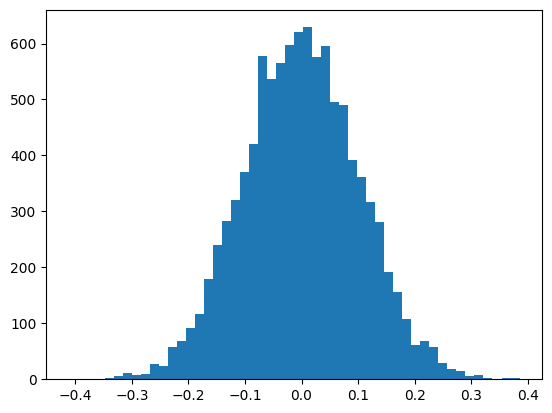

In [233]:
plt.hist(inpt, 50);

Let's pass this through a tanh function.

In [235]:
t1 = torch.tanh(inpt)
t1.std()

tensor(0.1008)

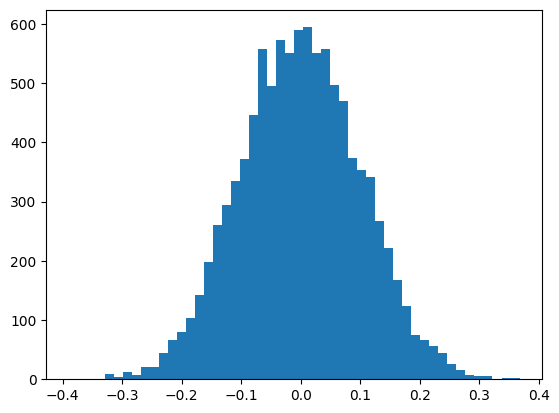

In [236]:
plt.hist(t1, 50);

The distribution is now within -4 and 4, after applying the tanh function. Let's apply it one more time.

In [237]:
t2 = torch.tanh(t1)
t2.std()

tensor(0.0998)

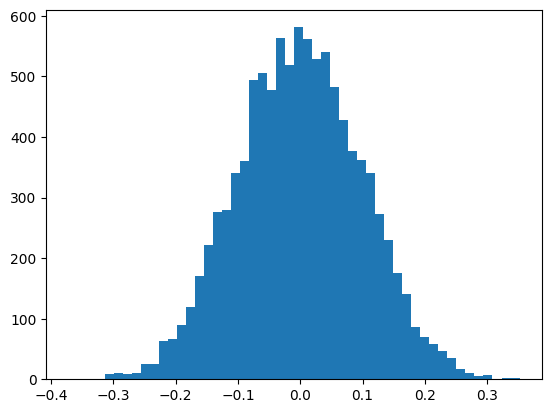

In [239]:
plt.hist(t2, 50);

As you can see, the t2 output is further squashed, and standard deviation reduced further. 
<p>This constant squashing as the signal goes through a deep layer of multiple tanh operations, will constantly keep bringing the signal closer and closer to 0. We do not want that. </p>


#### How do we fight it?
<p>As we noticed, above the standard deviation of the signal keeps getting lower and lower. What we actually want is after each layer, the standard deviation of the signal stays almost similar. If we settle on unit standard deviation, it should stay almost usnit SD after each layer.</p>
<p>The way to achieve this, is by applying certain <b>Gain</b> to the signal at the time of squashing. This gain fights the squashing function and tries to keep the SD of the signal almost the same.</p>

</br>This technique is called <b>Kaiming initialisation</b>. There is an amazing paper which goes deep into this concept that I invite you to read
[Here](https://arxiv.org/abs/1502.01852)

<p>Let's look at some examples.</p>

In [243]:
(torch.randn(100000) * 0.2).std()

tensor(0.2004)

<p>Whatever we multiply the input signal with while scaling down (0.2 in above example), becomes the standard deviation SD of the signal. According to Kaiming initialisation, we want this SD (or the multiplicative factor) to be almost similar.</p>

<p>But ofc, in a deep network, we will not keep multiplying each layer weights by some hard coded values. So how do we compute this standard deviation (or the multiplicative factor)?</p>

<p>According to the paper cited above, the formula to compute this standard diviation value is as follows:</p>
$$
    std = Gain / \sqrt{fanin}
$$

<p>What exactly is this <i>fan_in</i>? Let's consider the network that we have built. We have 32 input batch size. Each input has 3 characters. Each character has a 3 dimensional embedding. This, after flatting operation gave us an input with 9 features. This input with 9 features is fed to the hidden layer. This defines the number of weights each neuron will have. Hence, each neuron will need 9 weights. This value of 9 is the <b>Fan In </b> of the neuron. So the number of the features are are input to a neuron, is the fan in of the neuron.</p>

<br/>But what about the gain value? The gain value depends on the type of the activation function we are using.
<br/>
The following image shows various values of gains for different activation functions. We are using tanh, for which the gain is 5/3.

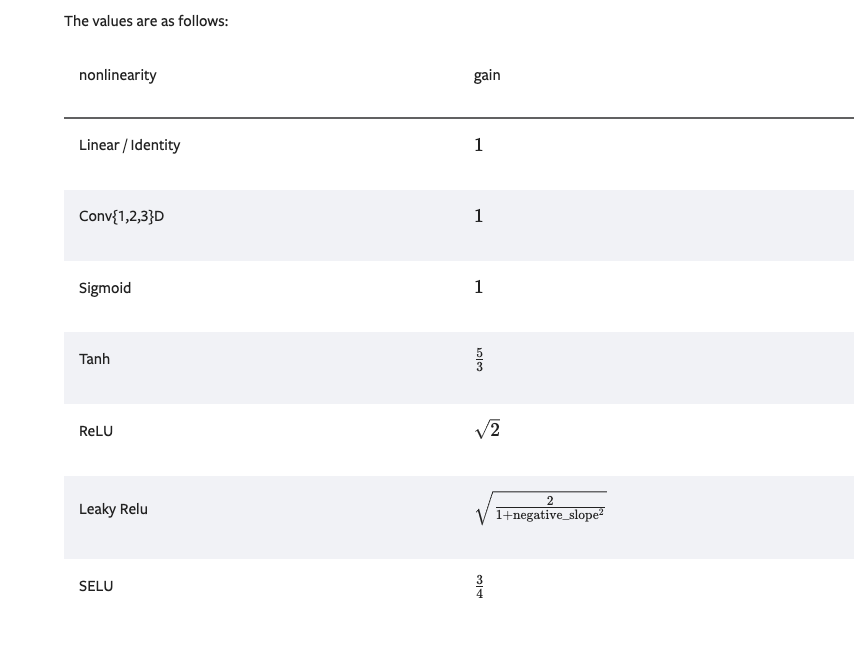

<br/>Let's compute what the std (or the multiplicative factor) should look like.


In [244]:
fanin = n_embed * block_size
std = (5/3) / fanin**0.5
std

0.5555555555555556

0.5 is the expected standard deviation that we want of the hidden layer. 
Let's retry the training of the model, which this generalised value of standard deviation of the hidden layer.
<p>According to Kaiming initialisation, the W1 vector will have std of <b>((5/3) / (n_embed * block_size) ** 0.5)</b></p>
<p>What will be the std of W2? W2 is linear layer. The gain for linear layer is 1. Hence std will be <b>1 / (n_hidden)**0.5</b></p>

In [249]:
n_embed = 3 # This is the dimentions of the embeddings. Each character will be defined as a 2D embedding
vocab_size = 27 # This is the size of the vocabulary.

n_hidden = 200
g = torch.Generator().manual_seed(2147483646)
C = torch.randn((vocab_size, n_embed), generator=g)

W1 = torch.randn((n_embed * block_size, n_hidden), generator=g) * ((5/3) / (n_embed * block_size) ** 0.5)
B1 = torch.randn(n_hidden, generator=g) * 0.01 # Scalled down to 0.01

W2 = torch.randn((n_hidden, vocab_size), generator=g) * (1 / n_hidden**0.5) # Gain for the linear layer is 1. Hence the std will be 1 / sqrt(fanin)
B2 = torch.randn(vocab_size, generator=g) * 0 # Initialised to zero.

parameters = [C, W1, B1, W2, B2]

# Let's set requires_grad to True for all parameters
for p in parameters: 
    p.requires_grad = True

In [250]:

lossi = []
epochs = 200000
batch_size = 32
for k in range (epochs):
    # forward pass
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    X_onehot = F.one_hot(Xtr[ix], num_classes=vocab_size).float()
    emb = X_onehot @ C
    embeddings = emb.flatten(start_dim=1, end_dim=-1)
    hpreact = embeddings @ W1 + B1
    h = torch.tanh(hpreact)
    logits = h @ W2 + B2
    # compute nll loss
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())
    # update the grad to None
    for p in parameters: 
        p.grad = None

    # Backward pass 
    loss.backward()
    
    
    # Update the values of the parameters 
    e = 0.1 if k < 100000 else 0.01
    for p in parameters: 
        p.data -= e * p.grad

    if k % 50000 == 0:
        print(f"loss: {loss}")

    lossi.append(loss.log10().item())

loss: 3.4766335487365723
loss: 2.36616587638855
loss: 2.0832180976867676
loss: 1.6934459209442139


In [251]:
print(f"Train loss: {evaluate_loss('train')}")
print(f"Validation loss: {evaluate_loss('validation')}")

Train loss: 2.1180949211120605
Validation loss: 2.152906656265259


With the acurate initialisation using Kaiming, we were able to bring validation gain further down! From 2.16, it came down to 2.15.

### Are the precise settings of weights at the time of initialisation really relevant today? Would I have to actually think about each layer's weights and initialise them with this Kaiming initialisation technique?
The answer to this question is, no. Given the modern advances in NNs, these initialisations have been taken over by more advanced techniques, one of which is called <b>Batch Normalisation</b>.

### What is Batch normalisation?
A team a Google in 2015 came up with Batch normalisation to effectively train very deep neual networds very reliably in that we don't have to worry about the pitfalls of saturated activations or too squashed activations. 

<p>So far using Kaiming initialisation technique, in order to make the hidden layer pre-activation states stay with a set standard deviation range, we were scaling the weights.</p>
<p>The radical idea that batch normalisation suggests is, "If you want to normalise the pre-activation layers to have a standard deviation within a range, why not just normalise the pre-activation states directly before feeding to tanh (or any other activation for that matter), instead of normalising the weights? Lol, that sounds too anticlimactic, but it actually just works.</p>

I invite you to read this paper by the team at Google. [Batch Normalization](https://arxiv.org/abs/1502.03167).

<p>Our pre-activation states are <i>hpreact</i>. Let' see how do we normalise it before feeding it to tanh.</p>

In [252]:
hpreact.shape

torch.Size([32, 200])

Shape of hpreact is [32, 200], since there are 200 neurons in total and the batch size is 32. For each neuron, there are 32 pre-activation states, one for each input in the batch size of 32. 

<br/>Let's look at the snippet of from the paper which tells how to normalise the pre-activation states.

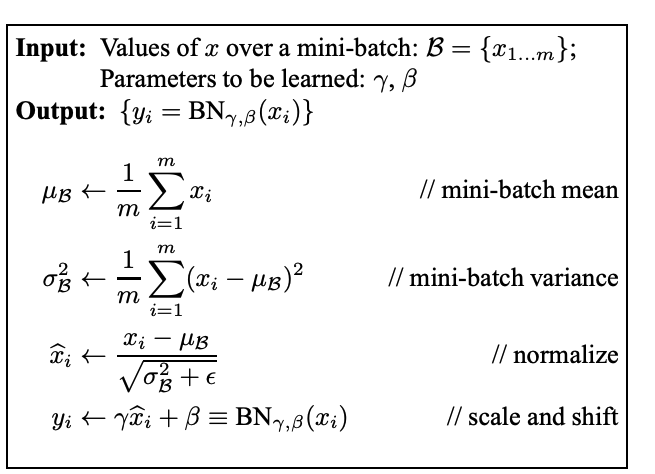

<p>According to this, we need mean and standard deviation of hpreact.Let's take the mean and standard deviation across the batch size for each neuron.</p>

In [254]:
hpreact.mean(0, keepdim=True).shape, hpreact.std(0, keepdim=True).shape

(torch.Size([1, 200]), torch.Size([1, 200]))

The shapes of mean and std are [1, 200], since we took the mean and std of the 32 inputs for each neuron.

According to this formula, the normalisation is achieved by the following (shown by '// normalize' line in the above image):
$$
    hpreact(standardised)= (hpreact - hpreactmean) / hpreactstd
$$

In [258]:
hpreact_normalized = (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True)
hpreact_normalized[0].mean(), hpreact_normalized[0].std()

(tensor(0.0386, grad_fn=<MeanBackward0>),
 tensor(0.7099, grad_fn=<StdBackward0>))

As can be seen above, the hpreact for neuron 0 is been normalised to have a mean near 0 and almost unit standard deviation.
<p>This function is applied to the pre-activation states (hpreact) during training.</p>

In [260]:
"""
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    X_onehot = F.one_hot(Xtr[ix], num_classes=vocab_size).float()
    emb = X_onehot @ C
    embeddings = emb.flatten(start_dim=1, end_dim=-1)
    hpreact = embeddings @ W1 + B1
    hpreact_normalized = (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True)
    h = torch.tanh(hpreact)
    logits = h @ W2 + B2
""";

<p>But, if you observe the code above, which is snippet of the forward pass of training, you'd realise that it does not normalize only at the time of initialisation, but instead it tries to normalize hpreact at every iteration. This indeed prevents hpreact to move about freely during training, resulting in hindering of the training process.</p>
<p>What we actually want, is to only have this normalization during initialisation, but hpreact should be allowed to move freely as it trains over iterations.</p>
<p>The way Batch Normalization solves this, is by the operation of <b>Scale and Shift</b>.</p>

Refer to the line '// scale and shift' in the image above.

$$
    hpreact(standardised) = yi ← γxbi + β
$$
Where γ and β are the learnable parameters, which at the beginning are 1s and 0s but they get updated during training, enabling the hpreact to move freely during training. 

<p>Scale (γ) parameter is initialised to 1s and shift (β) are initialised to 0s at the beginning, so that the formlua at the beginning is exactly what we saw in the beginning. </p>

$$
    hpreact(standardised)= (hpreact - hpreactmean) / hpreactstd
$$

But as these scale and shift parameters learn, they do not restrict hpreact to remain in the std range of 1. 

In [268]:
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bngain.shape, bnbias.shape

(torch.Size([1, 200]), torch.Size([1, 200]))

Hence, the forward pass becomes the following. Let's train and check.Remember to add bngain and bnbias to the parameters of the model, as these are learnable parameters.

In [286]:
n_embed = 3 # This is the dimentions of the embeddings. Each character will be defined as a 2D embedding
vocab_size = 27 # This is the size of the vocabulary.

n_hidden = 200
g = torch.Generator().manual_seed(2147483646)
C = torch.randn((vocab_size, n_embed), generator=g)

W1 = torch.randn((n_embed * block_size, n_hidden), generator=g) #* ((5/3) / (n_embed * block_size) ** 0.5)
B1 = torch.randn(n_hidden, generator=g) * 0.01 # Scalled down to 0.01

W2 = torch.randn((n_hidden, vocab_size), generator=g) * (1 / n_hidden**0.5) # Gain for the linear layer is 1. Hence the std will be 1 / sqrt(fanin)
B2 = torch.randn(vocab_size, generator=g) * 0 # Initialised to zero.

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

parameters = [C, W1, B1, W2, B2, bngain, bnbias]

# Let's set requires_grad to True for all parameters
for p in parameters: 
    p.requires_grad = True

In [287]:

lossi = []
epochs = 200000
batch_size = 32
for k in range (epochs):
    # forward pass
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    X_onehot = F.one_hot(Xtr[ix], num_classes=vocab_size).float()
    emb = X_onehot @ C
    embeddings = emb.flatten(start_dim=1, end_dim=-1)
    hpreact = embeddings @ W1 + B1
    
    hpreact_normalised = bngain * ((hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True)) + bnbias
    h = torch.tanh(hpreact_normalised)
    logits = h @ W2 + B2
    # compute nll loss
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())
    # update the grad to None
    for p in parameters: 
        p.grad = None

    # Backward pass 
    loss.backward()
    
    
    # Update the values of the parameters 
    e = 0.1 if k < 100000 else 0.01
    for p in parameters: 
        p.data -= e * p.grad

    if k % 50000 == 0:
        print(f"loss: {loss}")

    lossi.append(loss.log10().item())

loss: 3.3478477001190186
loss: 2.381439685821533
loss: 2.5067310333251953
loss: 1.8668248653411865


In [288]:
@torch.no_grad()
def evaluate_loss_with_bn(split):
    x, y = {
        'train': (Xtr, Ytr),
        'validation': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]

    X_onehot = F.one_hot(x, num_classes=vocab_size).float()
    emb = X_onehot @ C
    embeddings = emb.flatten(start_dim=1, end_dim=-1)
    hpreact = embeddings @ W1 + B1
    hpreact_normalised = bngain * ((hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True)) + bnbias
    h = torch.tanh(hpreact_normalised)
    logits = h @ W2 + B2
    loss = F.cross_entropy(logits, y)
    return loss

In [289]:
print(f"Train loss: {evaluate_loss_with_bn('train')}")
print(f"Validation loss: {evaluate_loss_with_bn('validation')}")

Train loss: 2.184086322784424
Validation loss: 2.1984779834747314


We have updated the forward pass of the loss computation function to include the batch normalization step.

### The Batch Normalization comes at a terrible cost.
Earlier, the hpreact of an input in a batch, only depended on that input. Even though we were training the model in batches of 32, the hpreact was only a function of a single input. That made the hpreact deterministic. 
<p>But due to the computation of mean and std for a batch, and using it to normalize the hpreact signal, we made the hpreact of an input not only the function of the corresponding input but all the inputs inside the batch.</p>
<p>This adds some jitter or noise in hpreact, since mean and std depends on other inputs as well. This, in theory should be a bad thing. But actually, due to this noise, it makes the training more efficient, as it prevents the model to be overfitted to specific inputs.</p>

### One more thing to notice here is, the test functon now takes a batch instead of a single input. How will we infer from this model, if it relies on a batch?
To get around this, there is an added step after training. We essentially compute the mean and the std over the entire dataset and use those values during testing and inference, enabling us to pass a single input. 

In [291]:
with torch.no_grad():
    X_onehot = F.one_hot(Xtr, num_classes=vocab_size).float()
    emb = X_onehot @ C
    embeddings = emb.flatten(start_dim=1, end_dim=-1)
    hpreact = embeddings @ W1 + B1
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [292]:
@torch.no_grad()
def evaluate_loss_with_bn_precomp(split):
    x, y = {
        'train': (Xtr, Ytr),
        'validation': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]

    X_onehot = F.one_hot(x, num_classes=vocab_size).float()
    emb = X_onehot @ C
    embeddings = emb.flatten(start_dim=1, end_dim=-1)
    hpreact = embeddings @ W1 + B1
    hpreact_normalised = bngain * ((hpreact - bnmean) / bnstd) + bnbias
    h = torch.tanh(hpreact_normalised)
    logits = h @ W2 + B2
    loss = F.cross_entropy(logits, y)
    return loss

In [293]:
print(f"Train loss: {evaluate_loss_with_bn_precomp('train')}")
print(f"Validation loss: {evaluate_loss_with_bn_precomp('validation')}")

Train loss: 2.184086322784424
Validation loss: 2.1984779834747314


We get the exact same validation loss as above. But with this, the model can now take a single input and not rely on the entire batch during testing and inference.

<p>This additional step after training is cumbursome. Can we not compute the mean and std while training?</p>
Well, we can. Let's see how we would do that.


In [302]:
n_embed = 3 # This is the dimentions of the embeddings. Each character will be defined as a 2D embedding
vocab_size = 27 # This is the size of the vocabulary.

n_hidden = 200
g = torch.Generator().manual_seed(2147483646)
C = torch.randn((vocab_size, n_embed), generator=g)

W1 = torch.randn((n_embed * block_size, n_hidden), generator=g) * ((5/3) / (n_embed * block_size) ** 0.5)
B1 = torch.randn(n_hidden, generator=g) * 0.01 # Scalled down to 0.01

W2 = torch.randn((n_hidden, vocab_size), generator=g) * (1 / n_hidden**0.5) # Gain for the linear layer is 1. Hence the std will be 1 / sqrt(fanin)
B2 = torch.randn(vocab_size, generator=g) * 0 # Initialised to zero.

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

bnmean_running = torch.zeros((1, n_hidden)) # initialise running mean
bnstd_running = torch.ones((1, n_hidden)) # initialise running std

parameters = [C, W1, B1, W2, B2, bngain, bnbias]

# Let's set requires_grad to True for all parameters
for p in parameters: 
    p.requires_grad = True

In [303]:

lossi = []
epochs = 200000
batch_size = 32
for k in range (epochs):
    # forward pass
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    X_onehot = F.one_hot(Xtr[ix], num_classes=vocab_size).float()
    emb = X_onehot @ C
    embeddings = emb.flatten(start_dim=1, end_dim=-1)
    hpreact = embeddings @ W1 + B1

    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    
    hpreact_normalised = bngain * ((hpreact - bnmeani) / bnstdi) + bnbias
    
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    h = torch.tanh(hpreact_normalised)

    
    logits = h @ W2 + B2
    # compute nll loss
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())
    # update the grad to None
    for p in parameters: 
        p.grad = None

    # Backward pass 
    loss.backward()
    
    
    # Update the values of the parameters 
    e = 0.1 if k < 100000 else 0.01
    for p in parameters: 
        p.data -= e * p.grad

    if k % 50000 == 0:
        print(f"loss: {loss}")

    lossi.append(loss.log10().item())

loss: 3.3767499923706055
loss: 2.1419811248779297
loss: 2.0966620445251465
loss: 2.2530078887939453


In the above changes, we will are computing the running mean and std at the time of training. We have put that under torch.no_grad, since we don't want torch to keep track of their operations, since we will never call backward on them.

In [304]:
@torch.no_grad()
def evaluate_loss_with_bn_running(split):
    x, y = {
        'train': (Xtr, Ytr),
        'validation': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]

    X_onehot = F.one_hot(x, num_classes=vocab_size).float()
    emb = X_onehot @ C
    embeddings = emb.flatten(start_dim=1, end_dim=-1)
    hpreact = embeddings @ W1 + B1
    hpreact_normalised = bngain * ((hpreact - bnmean_running) / bnstd_running) + bnbias
    h = torch.tanh(hpreact_normalised)
    logits = h @ W2 + B2
    loss = F.cross_entropy(logits, y)
    return loss

In [305]:
print(f"Train loss: {evaluate_loss_with_bn_running('train')}")
print(f"Validation loss: {evaluate_loss_with_bn_running('validation')}")

Train loss: 2.17045521736145
Validation loss: 2.18615984916687


The validation loss is unaffected above.

### Where to add these batch normalization layers in the network?
It is a good practise to sprinkle these batch normalization layers after linear layers (whereever there is multiplicative operation like x @ W). 

In [306]:
n_embed = 3 # This is the dimentions of the embeddings. Each character will be defined as a 2D embedding
vocab_size = 27 # This is the size of the vocabulary.

n_hidden = 200
g = torch.Generator().manual_seed(2147483646)
C = torch.randn((vocab_size, n_embed), generator=g)

# ------ Hidden layer parameters -----------
W1 = torch.randn((n_embed * block_size, n_hidden), generator=g) * ((5/3) / (n_embed * block_size) ** 0.5)
B1 = torch.randn(n_hidden, generator=g) * 0.01 # Scalled down to 0.01

# --------- Output layer parameters ------------
W2 = torch.randn((n_hidden, vocab_size), generator=g) * (1 / n_hidden**0.5) # Gain for the linear layer is 1. Hence the std will be 1 / sqrt(fanin)
B2 = torch.randn(vocab_size, generator=g) * 0 # Initialised to zero.

# --------- Batch normalization parameters ---------------------
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

# -------------- Batch normalization buffers (these are not trained with back propogation) -----------------
bnmean_running = torch.zeros((1, n_hidden)) # initialise running mean
bnstd_running = torch.ones((1, n_hidden)) # initialise running std

parameters = [C, W1, B1, W2, B2, bngain, bnbias]

# Let's set requires_grad to True for all parameters
for p in parameters: 
    p.requires_grad = True


# ------------------ Training ----------------------

lossi = []
epochs = 200000
batch_size = 32
for k in range (epochs):
    # --------- forward pass ------------
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    X_onehot = F.one_hot(Xtr[ix], num_classes=vocab_size).float()
    emb = X_onehot @ C
    embeddings = emb.flatten(start_dim=1, end_dim=-1)

    # --------- Linear layer ---------------
    hpreact = embeddings @ W1 + B1

    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)

    # --------- Batch Normalization layer -----------------
    hpreact_normalised = bngain * ((hpreact - bnmeani) / bnstdi) + bnbias
    
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    # ---------- Activation layer -----------------
    
    h = torch.tanh(hpreact_normalised)

    # -------------- Output linear layer ------------------
    
    logits = h @ W2 + B2
    # compute nll loss

    # ------------- Softmax & nll layer ---------------------
    loss = F.cross_entropy(logits, Ytr[ix])

    # update the grad to None
    for p in parameters: 
        p.grad = None

    # Backward pass 
    loss.backward()
    
    
    # Update the values of the parameters 
    e = 0.1 if k < 100000 else 0.01
    for p in parameters: 
        p.data -= e * p.grad

    if k % 50000 == 0:
        print(f"loss: {loss}")

    lossi.append(loss.log10().item())

loss: 3.287585496902466
loss: 1.960916519165039
loss: 2.1940715312957764
loss: 2.235799551010132


In [307]:
@torch.no_grad()
def evaluate_loss_with_bn_running(split):
    x, y = {
        'train': (Xtr, Ytr),
        'validation': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]

    X_onehot = F.one_hot(x, num_classes=vocab_size).float()
    emb = X_onehot @ C
    embeddings = emb.flatten(start_dim=1, end_dim=-1)
    hpreact = embeddings @ W1 + B1
    hpreact_normalised = bngain * ((hpreact - bnmean_running) / bnstd_running) + bnbias
    h = torch.tanh(hpreact_normalised)
    logits = h @ W2 + B2
    loss = F.cross_entropy(logits, y)
    return loss

In [308]:
# ---------------- Test and validation -----------------

print(f"Train loss: {evaluate_loss_with_bn_precomp('train')}")
print(f"Validation loss: {evaluate_loss_with_bn_precomp('validation')}")

Train loss: 2.391275405883789
Validation loss: 2.391932249069214
